In [1]:
### Change Point Model ###
from change_detection import ChangePointDetector
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
import sys 
sys.path.append('../../../')
from main import Manager 
m = Manager('../../../')
from bin.plots.volume_oi_chart import price_volume_oi_chart
from bin.utils.tools import pretty_print

2025-05-13 00:28:04,134 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-13 00:28:04,135 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-13 00:28:04,136 - INFO - PriceDB Initialized successfully at 2025-05-13 00:28:04.136442
2025-05-13 00:28:04,136 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-13 00:28:04.136442
2025-05-13 00:28:04,136 - INFO - Established 3 database connections
2025-05-13 00:28:04,136 - bin.price.db_connect - INFO - Established 3 database connections
2025-05-13 00:28:04,182 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


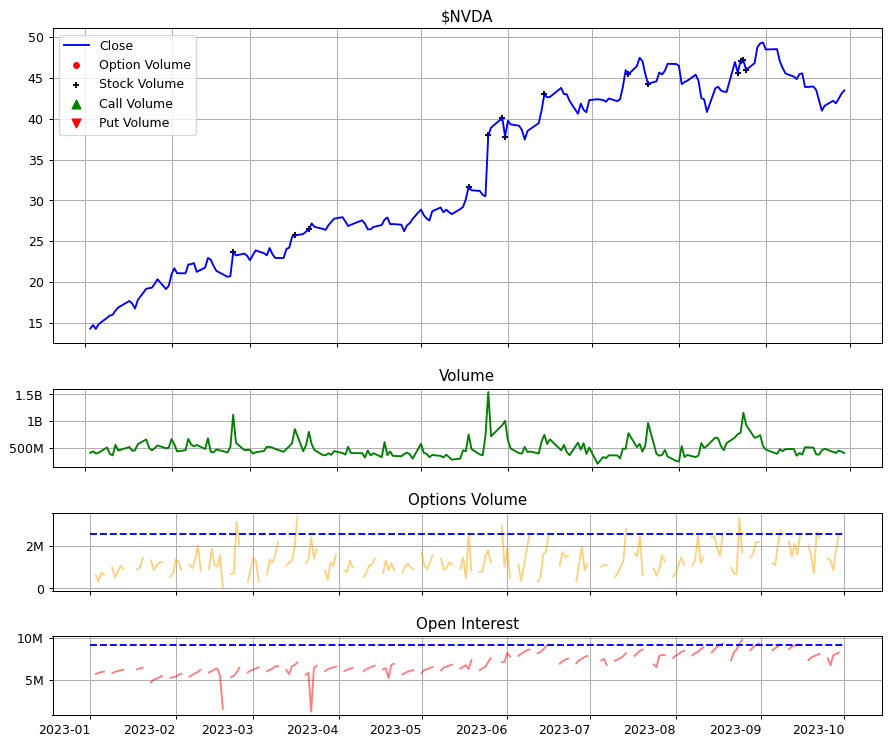

In [3]:
def get_aligned(stock):
    price_df = m.Pricedb.ohlc(stock)
    price_df =price_df.copy().sort_index()
    d = m.Optionsdb.get_daily_option_stats(stock).sort_index()
    d = d.resample('1D').sum()
    price_df = price_df.loc[d.index[0]:]
    d = d.replace(0, np.nan)
    return price_df, d

def show_volume_oi(stock, start_date = None, end_date = None):
    pdf, odf = get_aligned(stock)
    pdf.columns = [x.lower() for x in pdf.columns]
    fig, ax = plt.subplots(4, 1, height_ratios=[2, 0.5, 0.5, 0.5], figsize = (10, 10), dpi = 90)
    price_volume_oi_chart(odf, pdf, fig, ax, stock = stock, start_date=start_date, end_date=end_date)
    fig.show()
    return pdf, odf

_, _ = show_volume_oi('nvda', '2023-01-01', '2023-10-01')

In [4]:
from trend_results import TResults
tr = TResults(
    connections = '../../../',
    lookback_days= 90,
    window_size = 200, 
    period = 30
    
    )


2025-05-13 00:28:06,329 - bin.options.optgd.db_connect - INFO - Options DB Initialized
2025-05-13 00:28:06,329 - bin.options.optgd.db_connect - WARNING - You currently have 8 connections open.
2025-05-13 00:28:06,332 - INFO - PriceDB Initialized successfully at 2025-05-13 00:28:06.332184
2025-05-13 00:28:06,332 - bin.price.db_connect - INFO - PriceDB Initialized successfully at 2025-05-13 00:28:06.332184
2025-05-13 00:28:06,333 - INFO - Established 3 database connections
2025-05-13 00:28:06,333 - bin.price.db_connect - INFO - Established 3 database connections


2025-05-13 00:28:06,376 - bin.alerts.options_alerts - INFO - Notifications instance initialized.


In [5]:
results = tr.analyze_stocks()

Processing nvo: 100%|██████████| 134/134 [00:28<00:00,  4.64it/s, Success=1]


In [6]:
# Convert to DataFrame
data = []
for i in results:
    for result in i:
        data.append({
            'stock': result.stock,
            'metric': result.name,
            'trend_direction': result.trend_direction,
            'seasonality': result.seasonality,
            'slope': result.slope,
            'change_point': result.change_point
        })
df = pd.DataFrame(data)

# Flag slope discrepancies (where trend direction and slope sign don't match)
df['slope_discrepancy'] = ((df['trend_direction'] == 'up') & (df['slope'] < 0)) | ((df['trend_direction'] == 'down') & (df['slope'] > 0))
print("DataFrame with Slope Discrepancies Flagged:")
df[df.slope_discrepancy == True]

DataFrame with Slope Discrepancies Flagged:


,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gme,close_prices,up,normal,-0.001241,1.0,True
3,gme,oi,up,high,-0.001301,0.0,True
5,gme,call_oi,up,high,-0.001159,0.0,True
6,gme,put_oi,up,high,-0.001460,0.0,True
12,amzn,oi,up,normal,-0.006390,0.0,True
...,...,...,...,...,...,...,...
1141,pct,call_volume,down,high,0.089592,1.0,True
1142,pct,put_volume,down,normal,0.084837,1.0,True
1154,tem,options_volume,up,normal,-0.011806,1.0,True
1159,tem,call_volume,up,normal,-0.008904,1.0,True


In [7]:
df.metric.unique()

array(['close_prices', 'stock_volume', 'options_volume', 'oi', 'atm_iv',
       'call_oi', 'put_oi', 'call_volume', 'put_volume'], dtype=object)

In [18]:
increasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_oi = df[(df.metric == 'call_oi') & (df.trend_direction == 'up')].stock.tolist()
decreasing_oi = df[(df.metric == 'oi') & (df.trend_direction == 'down')].stock.tolist()

increasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'up')].stock.tolist()
increasing_call_volume = df[(df.metric == 'call_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_options_volume = df[(df.metric == 'options_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price_volume = df[(df.metric == 'price_volume') & (df.trend_direction == 'down')].stock.tolist()

increasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'up')].stock.tolist()
decreasing_price = df[(df.metric == 'close_prices') & (df.trend_direction == 'down')].stock.tolist()


def print_10_items_per_line(title, lst):
    print(title)
    print("=====================================")
    for i in range(0, len(lst), 10):
        print(", ".join(lst[i:i+10]))


print_10_items_per_line("Decreasing Options Volume:", decreasing_options_volume)
print_10_items_per_line("Decreasing Price Volume:", decreasing_price_volume)

Decreasing Options Volume:
gme, amzn, aapl, pfe, pep, ntr, dkng, mdb, ups, pltr
wmt, cvx, fcel, vale, mo, intc, mu, hd, rrc, lc
vuzi, bkkt, lmt, wfc, crwd, mrk, baba, tsla, sol, mos
qs, msft, tgt, meta, abbv, ccj, ebay, f, pypl, ibm
amd, amc, xom, clsk, coin, asan, hsbc, kr, afrm, wba
ba, cmre, ge, intu, snap, nvda, ctva, aa, csco, ko
ctra, snow, li, run, lulu, oxy, c, abnb, x, mara
clx, jpm, k, sony, hood, cag, ual, pgr, afl, aig
avgo, sofi, mpw, arm, ttd, amat, open, dbx, panw, tdoc
smci, expe, djt, dell, dltr, adbe, orcl, u, tost, pct
oklo
Decreasing Price Volume:


In [19]:

print_10_items_per_line("Increasing OI:", list(set(increasing_oi + increasing_price)))
print_10_items_per_line("Increasing Call OI:", list(set(increasing_call_oi + increasing_price)))

Increasing OI:
goog, ba, pltr, cvx, ttd, arm, dbx, k, qcom, pfe
afl, wfc, u, rblx, nflx, clx, run, mpw, lmt, dltr
gsl, ko, c, pct, dkng, mrk, fang, ups, dell, mdb
cava, cvs, mmm, aapl, ntr, afrm, aig, enph, gme, tgt
amzn, mu, mos, x, eog, uber, crwd, f, sono, rtx
oxy, intu, mo, btu, hsbc, sol, hims, snow, amat, rkt
aal, ge, pypl, aa, pgr, hd, spot, wmt, kr, dis
meta, jpm, v
Increasing Call OI:
pltr, cvx, arm, dbx, k, qcom, afl, wfc, u, rblx
nflx, clx, run, mpw, dltr, lmt, tsn, abbv, ko, c
pct, mrk, fang, ups, dell, mdb, cvs, aapl, ntr, afrm
aig, enph, gme, tgt, mos, x, uber, crwd, f, sono
rtx, oxy, mo, intu, btu, hsbc, sofi, sol, hims, snow
amat, rkt, aal, ge, pypl, aa, pgr, spot, wmt, kr
dis, meta, jpm, sony, v


In [36]:
b = set(increasing_options_volume) & set(increasing_price) & set(increasing_call_volume) & set(increasing_call_oi)
b = set(increasing_options_volume) & set(increasing_price) 
print(b)

{'uber', 'spot', 'cvs', 'rblx', 'nflx'}


,total_vol,call_vol_chng,put_vol_chng,total_oi,call_oi,call_oi_chng,put_oi,put_oi_chng
date,,,,,,,,
2025-05-08,"73,453.00","-71,629.00","-7,208.00","1,456,094.00","757,200.00","22,176.00","698,894.00","1,104.00"
2025-05-09,"60,386.00","-26,779.00","-1,777.00","1,451,914.00","751,946.00","-5,254.00","699,968.00","1,074.00"
2025-05-10,nan,nan,nan,nan,nan,nan,nan,nan
2025-05-11,nan,nan,nan,nan,nan,nan,nan,nan
2025-05-12,"104,173.00","6,656.00","36,551.00","1,411,586.00","724,854.00","-27,092.00","686,732.00","-13,236.00"


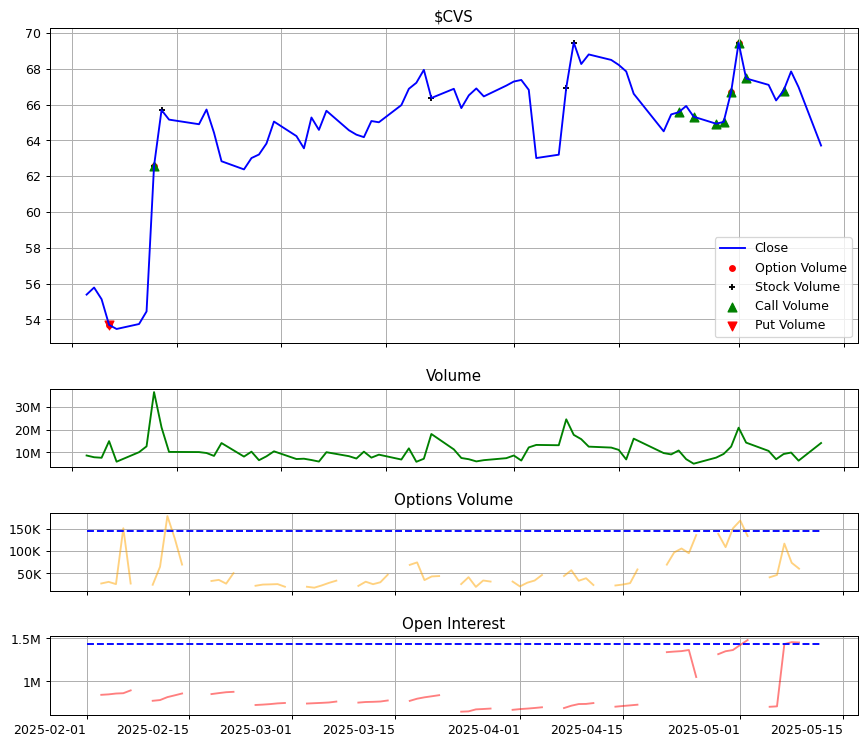

In [38]:
_, odf = show_volume_oi('cvs',start_date = "2025-02-01")

pretty_print(odf[['total_vol', 'call_vol_chng', 'put_vol_chng', 'total_oi', 'call_oi','call_oi_chng', 'put_oi','put_oi_chng']].tail())

In [12]:
change_df = df[df.change_point == 1]
call_volume_change = list(change_df[change_df.metric.isin(['call_volume'])].stock.unique())
put_volume_change = list(change_df[change_df.metric.isin(['put_volume'])].stock.unique())
print_10_items_per_line('Call Change Points',call_volume_change)

Call Change Points
gme, goog, dkng, intc, wfc, tsla, rkt, coin, afrm, ba
nvda, cvs, run, mara, avgo, ttd, hims, expe, rddt, dltr
pct, oklo, tem, btu


,total_vol,total_prem,total_oi,call_vol,put_vol,call_oi,put_oi,call_iv,put_iv,atm_iv,...,call_oi_chng,put_oi_chng,call_iv_chng,put_iv_chng,atm_iv_chng,otm_iv_chng,call_vol_pct_chng,put_vol_pct_chng,call_oi_pct_chng,put_oi_pct_chng
date,,,,,,,,,,,,,,,,,,,,,
2025-05-08,143850.0,1.487015e+07,922498.0,75810.0,68040.0,560366.0,362132.0,2.265112,1.977227,2.465020,...,10914.0,12716.0,0.147131,-0.050837,0.221363,0.218822,-0.159527,0.159527,-0.007654,0.007654
2025-05-09,238974.0,1.612039e+07,1053162.0,160010.0,78964.0,631564.0,421598.0,1.493851,1.380333,1.393582,...,71198.0,59466.0,-0.874450,-0.535263,-1.083133,-0.385281,0.190682,-0.190682,-0.015521,0.015521
2025-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-12,191860.0,1.529411e+07,995136.0,133974.0,57886.0,621684.0,373452.0,1.322614,1.235177,1.263826,...,-9880.0,-48146.0,0.019829,0.049866,-0.015940,-0.265333,0.024868,-0.024868,0.050078,-0.050078


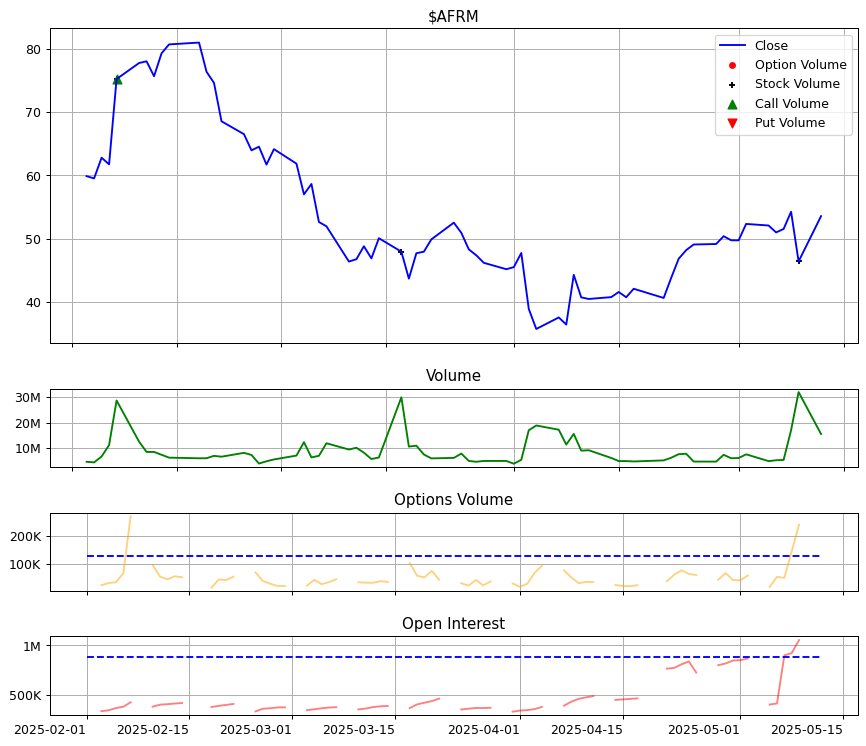

In [34]:
_, b = show_volume_oi('afrm', start_date = "2025-02-01")
b.tail()

In [14]:
df

,stock,metric,trend_direction,seasonality,slope,change_point,slope_discrepancy
0,gme,close_prices,up,normal,-0.001241,1.0,True
1,gme,stock_volume,up,high,0.022406,1.0,False
2,gme,options_volume,down,normal,-0.000417,1.0,False
3,gme,oi,up,high,-0.001301,0.0,True
4,gme,atm_iv,up,low,0.000833,1.0,False
...,...,...,...,...,...,...,...
1165,btu,atm_iv,up,normal,0.066859,1.0,False
1166,btu,call_oi,up,normal,0.012688,1.0,False
1167,btu,put_oi,up,normal,0.012151,1.0,False
1168,btu,call_volume,up,normal,0.012694,1.0,False
